<p style="text-align: center;"><em> Groupe 4 : Antoine Bouche, Myriam Ferchichi, Kiara Faisy</em></p>
<p style="display: flex; justify-content: space-between;">
  <span>FISA Info 24-27</span>
  <span>30/04/2025</span>
</p>



<h1 style="text-align: center;">Recherche Opérationnelle</h1>
<h1 style="text-align: center;">Livrable 2 - Livrable final du projet</h1>

# I - Introduction

Dans le cadre d’un appel d'offre lancé par l’ADEME, notre structure, CesiCDP, participe à un projet visant à développer de nouvelles solutions de mobilité pour les personnes et les marchandises. L’objectif est d’optimiser les déplacements afin de réduire la consommation énergétique et l’impact environnemental.

Pour cela, nous nous penchons sur la réalisation d'un algorithme permettant de calculer, sur un réseau routier, une tournée reliant un sous-ensemble de villes, avec retour au point de départ, tout en minimisant la durée totale du parcours afin de limiter les déplacements et réduire la consommation d'énergie des véhicules. 

Dans ce livrable nous metterons en oeuvre les différents algorithmes afin de comparer leurs performances.

# II - Création des instances

## Création de la fonction de création d'instance du TSP

In [1]:
!pip install networkx
!pip install pulp==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 84.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import random
from pulp import *
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from functools import lru_cache
from collections import deque
from mpl_toolkits.mplot3d import Axes3D
import time

Pour commencer, nous allons réaliser deux fonctions permettant de générer des instances de notre problème.

In [3]:
def creer_instance_TSP(nb_villes, reserve_essence):
    """Créer une instance du TSP"""
    # Créer une matrice de distance aléatoire entre les villes
    matrice_distance = [[0 for _ in range (nb_villes) ] for _ in range (nb_villes)]

    # Remplir la matrice de distance avec des valeurs aléatoires
    for i in range(nb_villes): 
        for j in range(i+1, nb_villes):
            distance = random.randint(1,10)
            matrice_distance[i][j] = distance
            matrice_distance[j][i] = distance
    
    collecte_index = [random.choice([True, False]) for _ in range(nb_villes)]
    collecte_index[0] = True
    
    liste_station = assigner_stations(nb_villes, collecte_index, reserve_essence)

    liste_ville_collecte = []
    liste_depot = []

    for i in range (nb_villes) :
        if collecte_index[i]:  # Si c'est True => ville de collecte
            liste_ville_collecte.append(i)
        else:
            liste_depot.append(i)

    return matrice_distance, collecte_index, liste_ville_collecte, liste_depot, liste_station

def assigner_stations(nb_villes, collecte_index, reserve_essence):
    
    liste_station = [False] * nb_villes

    min_stations = math.ceil(nb_villes / reserve_essence)
    
    # Choisir aléatoirement des indices pour les stations
    indices_possibles = list(range(nb_villes))
    random.shuffle(indices_possibles)                       # Mélanger les indices

    for i in range(min_stations):
        liste_station[indices_possibles[i]] = True

    # Vérifier que le nombre de station est suffisant dans les villes de collecte
    villes_collecte = [i for i in range(nb_villes) if collecte_index[i]]
    nb_collecte = len(villes_collecte)
    min_stations_collecte = math.ceil(nb_collecte / reserve_essence)

    stations_collecte = [i for i in villes_collecte if liste_station[i]]
    while len(stations_collecte) < min_stations_collecte:
        candidats = [i for i in villes_collecte if not liste_station[i]]
        if not candidats:
            break
        choix = random.choice(candidats)
        liste_station[choix] = True
        stations_collecte.append(choix)

    # Vérifier que le nombre de station est suffisant dans les villes de dépôt
    villes_depot = [i for i in range(nb_villes) if not collecte_index[i]]
    nb_depot = len(villes_depot)
    min_stations_depot = math.ceil(nb_depot / reserve_essence)

    stations_depot = [i for i in villes_depot if liste_station[i]]
    while len(stations_depot) < min_stations_depot:
        candidats = [i for i in villes_depot if not liste_station[i]]
        if not candidats:
            break
        choix = random.choice(candidats)
        liste_station[choix] = True
        stations_depot.append(choix)

    return liste_station

## Création de la fonction de génération de graphiques

Maintenant, nous réalisons une fonction permettant d'afficher nos instances sous forme de graphiques pour mieux les visualiser.

In [4]:
def generate_graph(matrice_distance, collecte_index, liste_station, show):
    nb_villes = len(matrice_distance)
    G = nx.Graph()

    for i in range(nb_villes):
        G.add_node(i, collecte=collecte_index[i], station=liste_station[i])

    for i in range(nb_villes):
        for j in range(i+1, nb_villes):
            if matrice_distance[i][j] != 0:
                G.add_edge(i, j, weight=matrice_distance[i][j])

    pos = nx.spring_layout(G, seed=42)

    node_colors = []

    for i in range(nb_villes):
        # Collecte → vert, Livraison → orange
        node_colors.append('green' if collecte_index[i] else 'orange')


    plt.figure(figsize=(20, 10), facecolor='white')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    # Dessiner les stations avec bordure noire épaisse
    node_border_colors = ['blue' if liste_station[i] else 'white' for i in range(nb_villes)]

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        edgecolors=node_border_colors,
        linewidths=2,
        node_size=700
    )

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # Légende
    import matplotlib.patches as mpatches
    collecte_patch = mpatches.Patch(color='green', label='Ville de collecte')
    livraison_patch = mpatches.Patch(color='orange', label='Ville de livraison')
    station_patch = mpatches.Patch(edgecolor='blue', facecolor='white', label='Station essence')
    plt.legend(handles=[collecte_patch, livraison_patch, station_patch], loc='upper left')
    plt.axis('off')
    if show :
        plt.show()
    else :
        return pos




def afficher_chemin(matrice_distance, chemin, collecte_index, liste_station):
    pos = generate_graph(matrice_distance, collecte_index, liste_station, False)
    chemin_complet = chemin + [chemin[0]] # Retour à la ville de départ
    G_chemin = nx.DiGraph()
    G_chemin.add_edges_from(chemin_complet)

    nx.draw_networkx_edges(
        G_chemin, pos,
        edgelist=chemin_complet,
        edge_color='red',
        arrows=True,
        arrowsize=20,
        width=2
    )

    plt.title("Chemin optimal sur le graphe TSP")
    plt.show()

## Générer une instance du TSP et initialiser les paramètres

In [5]:
reserve_essence = 5
nb_villes = 10
matrice_instance, collecte_index, liste_collecte, liste_depot, liste_stations = creer_instance_TSP(nb_villes, reserve_essence)

## Afficher le graphique correspondant à l'instance

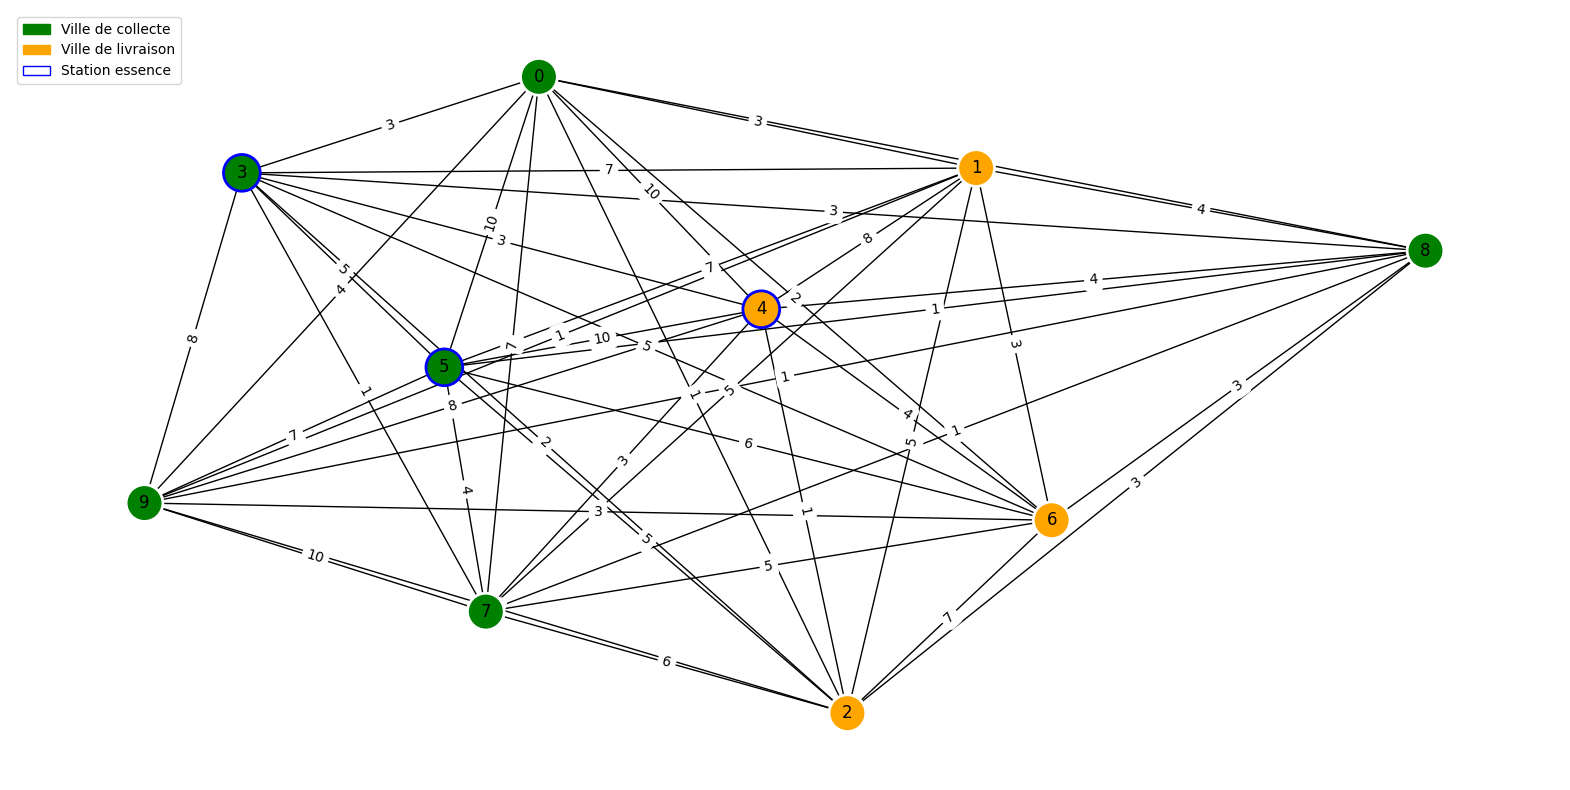

In [6]:
# Afficher le graphique
generate_graph(matrice_instance, collecte_index, liste_stations, True)

Nous réalisons une fonction permettant de reconstituer le chemin optimal

In [7]:
# Recontruire le chemin optimal
def reconstituer_chemin_optimal(x, n):
    chemin = []
    ville_actuelle = 0
    visitées = set()
    
    while len(chemin) < n:
        for j in range(n):
            if j != ville_actuelle and value(x[ville_actuelle][j]) == 1:
                chemin.append((ville_actuelle, j))
                visitées.add(ville_actuelle)
                ville_actuelle = j
                break
    return chemin

# III - Création des différents algorithmes

## A - Résolution à l'aide du PLNE

Commençons par modéliser le problème sous la forme d'un programme linéaire. <br />

### Variables de décision
<em>$x_{ij} \in \{0,1\} \quad \forall i,j \in \{0,\dots,n-1\}, i \neq j$  </em>

Où :
- $x_{ij} = 1$ si l'arc entre la ville $i$ et $j$ est sélectionné dans le tour
- $x_{ij} = 0$ sinon

### Paramètres
- $c_{ij}$ : coût/distance entre les villes $i$ et $j$
- $n$ : nombre total de villes
- $u_i$ : variable auxiliaire entière pour l'ordre de visite (contrainte MTZ)

### Contraintes

1. **Entrée unique** :  
   $\sum_{i \neq j} x_{ij} = 1 \quad \forall j \in \{0,\dots,n-1\}$  
   *Chaque ville a exactement un prédécesseur dans le tour*

2. **Sortie unique** :  
   $\sum_{j \neq i} x_{ij} = 1 \quad \forall i \in \{0,\dots,n-1\}$  
   *Chaque ville a exactement un successeur dans le tour*

3. **Pas de boucles** :  
   $x_{ii} = 0 \quad \forall i \in \{0,\dots,n-1\}$  
   *Interdiction des arcs d'une ville vers elle-même*

4. **Élimination des sous-tours (MTZ)** :  
   $u_i - u_j + (n-1)x_{ij} \leq n-2 \quad \forall i \neq j; i,j \in \{1,\dots,n-1\}$  
   $0 \leq u_i \leq n-1 \quad \forall i \in \{1,\dots,n-1\}$  
   *Garantit un tour unique en imposant un ordre de visite*

5. **Contraintes logistiques spécifiques** :  
   - *Collecte avant dépôt* :  
     $u_i \leq u_j - 1 \quad \forall i,j \ | \ \text{collecte}[i]=1 \ \text{et} \ \text{collecte}[j]=0$  
   - *Stations-service* :  
     $\sum_{k=i}^{i+\text{reserve}-1} x_{k,j} \cdot \text{station}[j] \geq 1 \quad \forall i \in \{0,\dots,n-\text{reserve}\}$  
     *(Au moins une station visitée dans chaque fenêtre de taille `reserve`)*

### Fonction économique
$\min \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} c_{ij} \cdot x_{ij}$  
*Minimisation du coût total du tour*

</em>

In [8]:
# Résolution du TSP avec PLNE
def resoudre_TSP_PLNE(matrice_distance, collecte_index, liste_station, k):
    n = len(matrice_distance)
    C = np.array(matrice_distance)

    x = [[LpVariable(f"x_{i}_{j}", cat="Binary") for j in range(n)] for i in range(n)]
    u = [LpVariable(f"u_{i}", lowBound=0, upBound=n - 1, cat="Integer") for i in range(n)]

    prob = LpProblem("TSP_avance", LpMinimize)

    # Objectif
    prob += lpSum(C[i][j] * x[i][j] for i in range(n) for j in range(n) if i != j)

    # Visite unique
    for i in range(n):
        prob += lpSum(x[i][j] for j in range(n) if j != i) == 1
        prob += lpSum(x[j][i] for j in range(n) if j != i) == 1

    # MTZ
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                prob += u[i] - u[j] + (n - 1)*x[i][j] <= n - 2

    # Contrainte collecte avant dépôt
    for i in range(n):
        for j in range(n):
            if collecte_index[i] and not collecte_index[j]:
                prob += u[i] <= u[j] - 1

    # Contrainte station-service toutes les k étapes
    for start in range(n - k + 1):
        prob += lpSum([LpVariable(f"s_{i}_{start}", cat="Binary") * int(liste_station[i])
                       for i in range(n)]) >= 1  # approximation

    # Résolution
    prob.solve()
    chemin = reconstituer_chemin_optimal(x, n)

    # # Affichage
    # # print("Status:", LpStatus[prob.status])
    # print("Coût total des arêtes :", value(prob.objective))
    # print("\nChemin optimal à parcourir :")

    # for i, j in chemin:
    #     print(f"{i} → ", end=""  )
    # print ("0")  # Retour à la ville de départ
    # print("\nChemin détaillé :")
    # for i, j in chemin:
    #     info = f"{i} → {j} (coût {C[i][j]})"
    #     if liste_station[j]:
    #         info += " => station essence"
    #     print(info)

    return chemin



Nous allons résoudre une instance de notre problème via l'algorithme linéaire : 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /root/venv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/f7a43acb24ab4394aec5bc824681bd5d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/f7a43acb24ab4394aec5bc824681bd5d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 916 RHS
At line 1039 BOUNDS
At line 1158 ENDATA
Problem MODEL has 122 rows, 118 columns and 462 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.3333 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 62 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 5

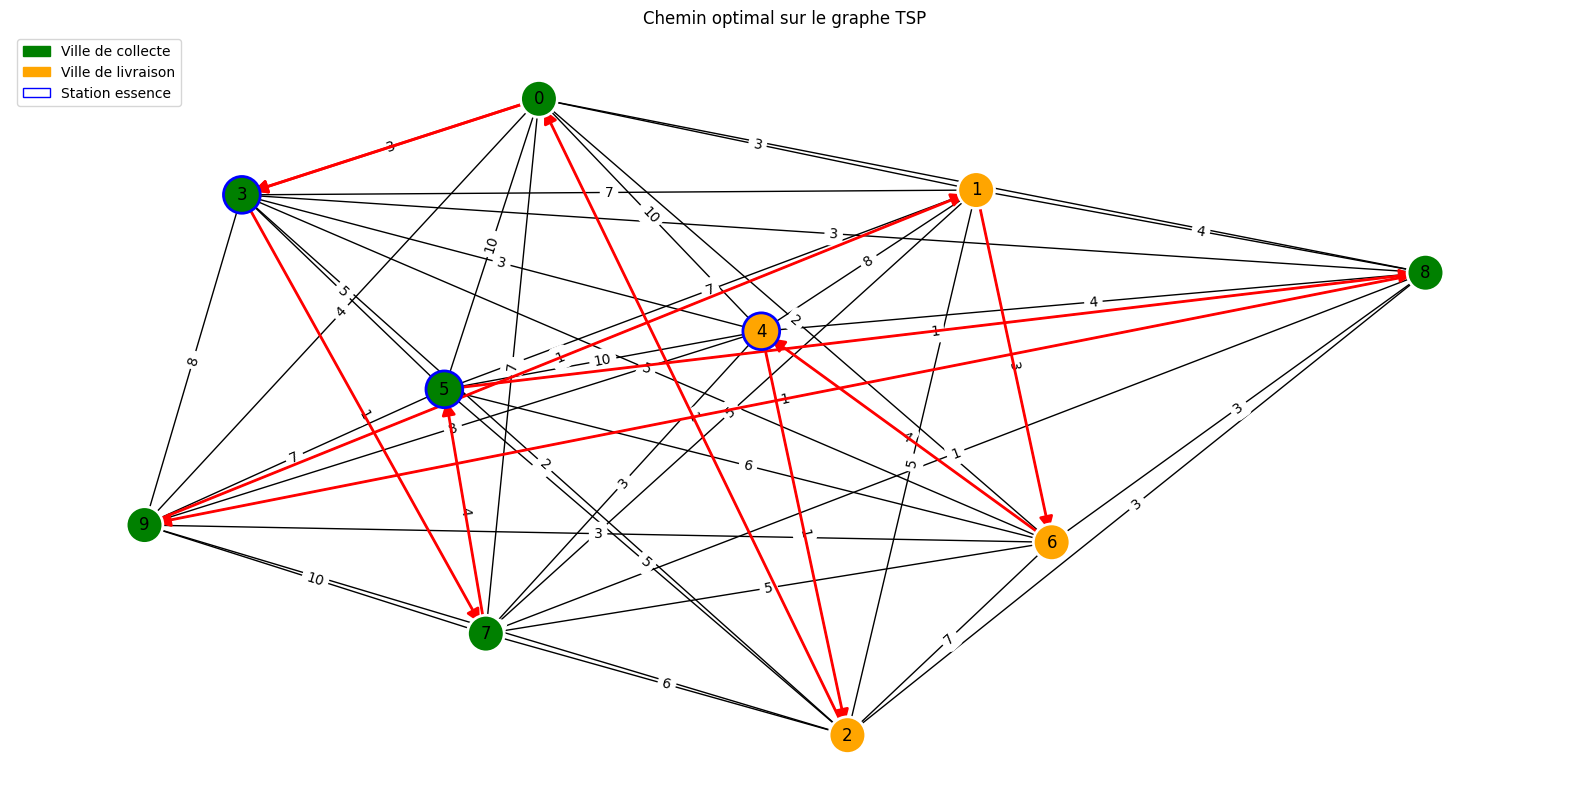

In [9]:
# Executer la résolution du TSP via PLNE
chemin_PLNE = resoudre_TSP_PLNE(matrice_instance, collecte_index, liste_stations, reserve_essence)
# Afficher le chemin résolu

afficher_chemin(matrice_instance, chemin_PLNE, collecte_index, liste_stations)


Il s'agit ici de la solution de notre problème dont la somme des arêtes est la plus faible. Mais cet algorithme n'est pas le plus optimal, c'est pourquoi nous avons décidé d'en faire d'autres et de les comparer par la suite.

## B - Résolution à l'aide de la recherche tabou

L'algorithme de Recherche Tabou est une métaheuristique d'optimisation. Il s'agit d'un algorithme de voisinage itératif qui explore l'espace des solutions via des mouvements locaux, mémorise les solutions récentes dans une liste tabou pour éviter les cycles et accepte temporairement des solutions sous-optimales (critère d'aspiration) pour échapper aux optima locaux.

Nous allons commencer par définir les fonctions nécessaires à la recherche tabou.

In [10]:

def random_solution(collectes, depots):
    """Réaliser une solution random"""
    # Enlever 0 de la liste avant de mélanger
    autres_collectes = [v for v in collectes if v != 0]
    
    random_collecte = [0] + random.sample(autres_collectes, len(autres_collectes))
    random_depot = random.sample(depots, len(depots))
    
    return random_collecte, random_depot

# @lru_cache(maxsize=None)
def calculer_distance(solution, distances):
    """Calculer la distance parcourue par notre chemin"""
    distance_totale = 0
    for i in range(len(solution) - 1):
        distance_totale += distances[solution[i]][solution[i + 1]]
    distance_totale += distances[solution[-1]][solution[0]]  # Retour à la ville de départ
    return distance_totale

def generer_voisins_solution(collectes, depots):
    """Générer tous les voisins de la solution"""
    voisins = []
    # Permutations dans les collectes (sans bouger 0)
    for i in range(1, len(collectes)):
        for j in range(i+1, len(collectes)):
            new_collecte = collectes.copy()
            new_collecte[i], new_collecte[j] = new_collecte[j], new_collecte[i]
            voisins.append((new_collecte, depots.copy()))
    # Permutations dans les dépôts
    for i in range(len(depots)):
        for j in range(i+1, len(depots)):
            new_depot = depots.copy()
            new_depot[i], new_depot[j] = new_depot[j], new_depot[i]
            voisins.append((collectes.copy(), new_depot))

    return voisins


In [11]:
def resoudre_TSP_Tabou(distances, chemin_collecte, chemin_depot, taille_tabou, iter_max):
    from math import inf

    nb_iter = 0
    liste_tabou = deque((), maxlen=taille_tabou)

    chemin_initial = chemin_collecte + chemin_depot

    solution_courante = chemin_initial
    meilleure = chemin_initial
    meilleure_globale = chemin_initial

    valeur_meilleure = calculer_distance(chemin_initial, distances)
    valeur_meilleure_globale = valeur_meilleure

    # Pour enregistrer l'évolution des valeurs de la solution courante et la meilleure
    courantes = []
    meilleures_courantes = []

    while nb_iter < iter_max:
        nb_iter += 1
        valeur_meilleure = inf
        meilleur_voisin = None

        # Re-décomposer la solution courante
        solution_collecte = solution_courante[:len(chemin_collecte)]
        solution_depot = solution_courante[len(chemin_collecte):]


        for voisin in generer_voisins_solution(solution_collecte, solution_depot):
            chemin_voisin = voisin[0] + voisin[1]
            valeur_voisin = calculer_distance(chemin_voisin, distances)

            if valeur_voisin < valeur_meilleure and chemin_voisin not in liste_tabou:
                valeur_meilleure = valeur_voisin
                meilleur_voisin = chemin_voisin

        if meilleur_voisin is None:
            break  # Aucun voisin non tabou trouvé, on arrête

        if valeur_meilleure < valeur_meilleure_globale:
            meilleure_globale = meilleur_voisin
            valeur_meilleure_globale = valeur_meilleure
            nb_iter = 0  # Réinitialiser les itérations quand une meilleure solution est trouvée

        # Ajouter les valeurs pour le graphique
        meilleures_courantes.append(valeur_meilleure_globale)
        courantes.append(valeur_meilleure)

        # Passer au meilleur voisin non tabou trouvé
        solution_courante = meilleur_voisin
        liste_tabou.append(solution_courante)

    return meilleure_globale, valeur_meilleure_globale, courantes, meilleures_courantes



### Résolution de notre problème via un appel à la recherche tabou

[0, 3, 7, 5, 8, 9, 1, 6, 4, 2] 20


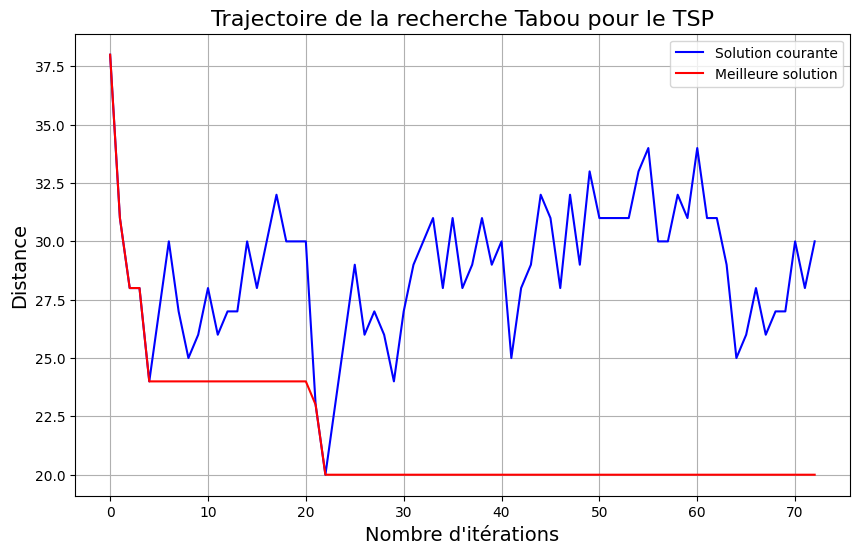

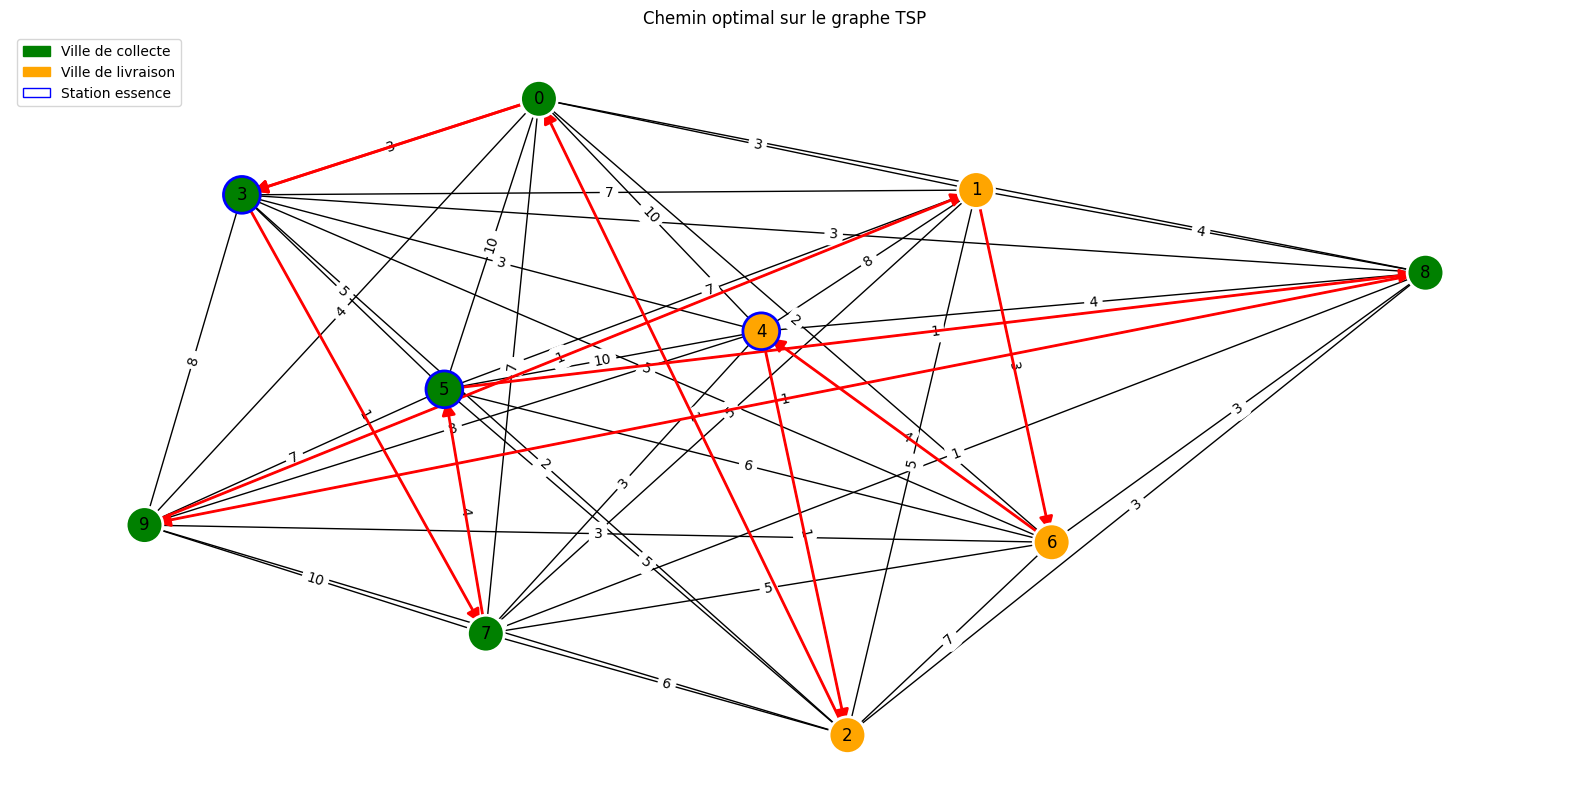

In [12]:
# Appel de la fonction pour résoudre le TSP
random_collecte, random_depot = random_solution(liste_collecte, liste_depot)
taille_tabou = 50
iter_max = 50
chemin_tabou, cout_chemin, valeur_courante, valeur_meilleur = resoudre_TSP_Tabou(matrice_instance, random_collecte, random_depot, taille_tabou, iter_max)

print(chemin_tabou, cout_chemin)

# Tracer les courbes
plt.figure(figsize=(10, 6))  # Pour une taille de graphique plus lisible
plt.plot(range(len(valeur_courante)), valeur_courante, label="Solution courante", color='blue')
plt.plot(range(len(valeur_meilleur)), valeur_meilleur, label="Meilleure solution", color='red')

# Ajouter des labels et une légende
plt.xlabel("Nombre d'itérations", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.title("Trajectoire de la recherche Tabou pour le TSP", fontsize=16)
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

# Créer une liste de tuples représentant les arêtes
chemin_tabou_tuple = [(chemin_tabou[i], chemin_tabou[i+1]) for i in range(len(chemin_tabou) - 1)] + [(chemin_tabou[-1], chemin_tabou[0])]

afficher_chemin(matrice_instance, chemin_tabou_tuple, collecte_index, liste_stations)


### Optimiser les résultats de la recherche tabou

Notre objectif est désormais de définir la taille tabou et le nombre d'itération optimal au bon fonctionnement de notre algorithme.

Pour cela, nous allons comparer sur 4 graphiques les résultats obtenu avec des valeurs de 10 et 100 pour une instance de 20 villes et 5 routes maximales avant la station essence.

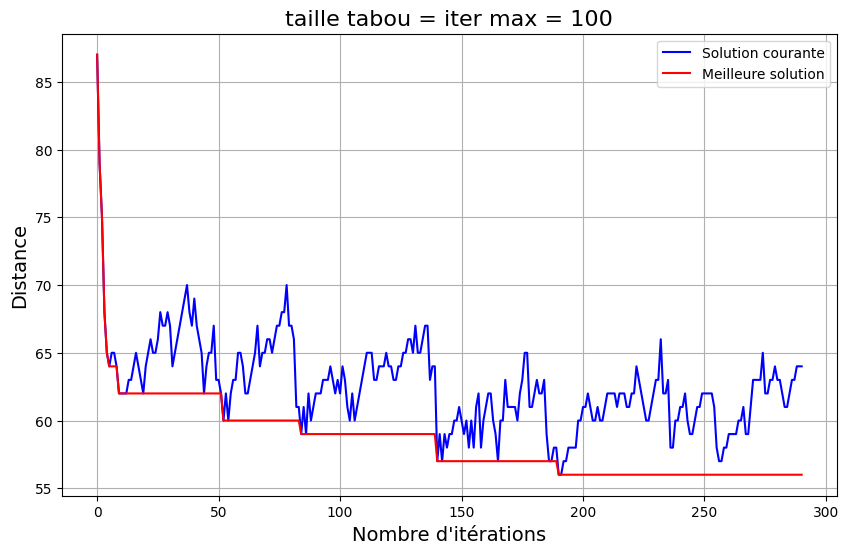

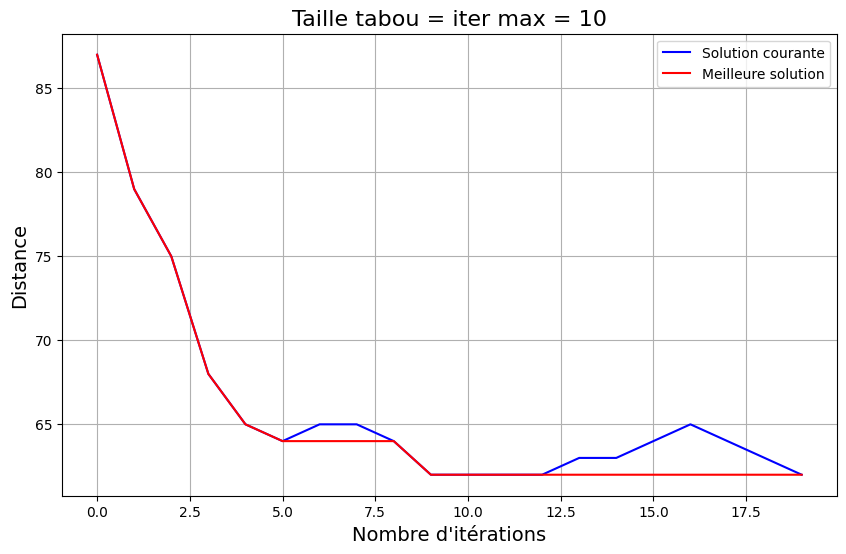

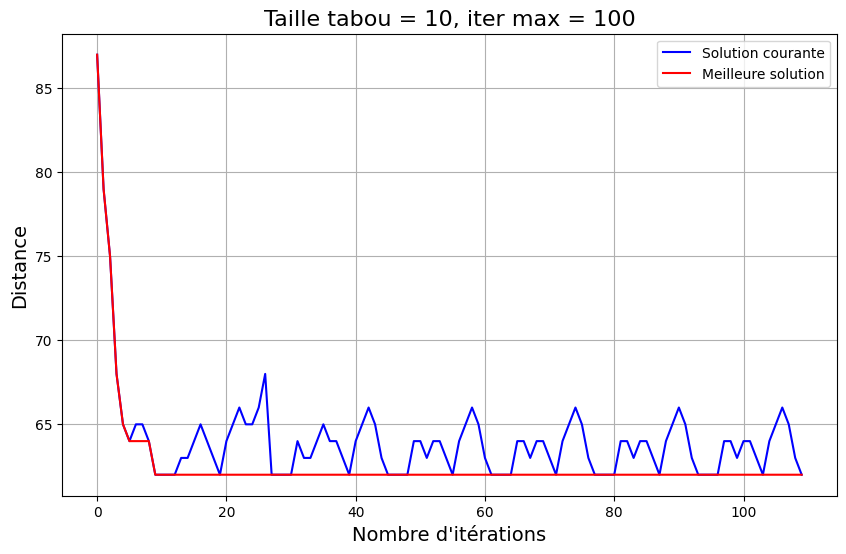

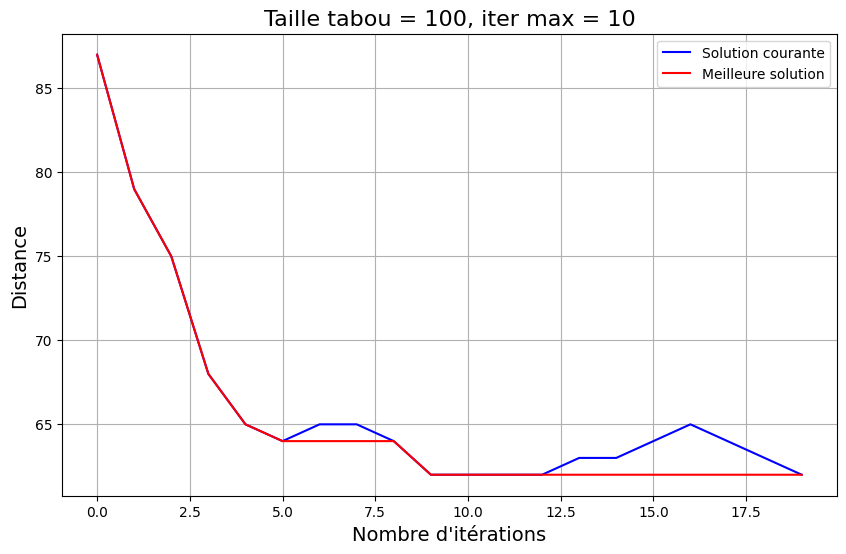

In [13]:
reserve_essence_tabou = 5
nb_villes_tabou = 20
matrice_tabou, collecte_index_tabou, liste_collecte_tabou, liste_depot_tabou, liste_stations_tabou = creer_instance_TSP(nb_villes_tabou, reserve_essence_tabou)


# Appel de la fonction pour résoudre le TSP
random_collecte_tabou, random_depot_tabou = random_solution(liste_collecte_tabou, liste_depot_tabou)

taille_tabou_c = 100
iter_max_c = 100
taille_tabou_d = 10
iter_max_d = 10

# POUR 100 - 100
chemin_tabou, cout_chemin, valeur_courante, valeur_meilleur = resoudre_TSP_Tabou(matrice_tabou, random_collecte_tabou, random_depot_tabou, taille_tabou_c, iter_max_c)

# Tracer les courbes
plt.figure(figsize=(10, 6))  # Pour une taille de graphique plus lisible
plt.plot(range(len(valeur_courante)), valeur_courante, label="Solution courante", color='blue')
plt.plot(range(len(valeur_meilleur)), valeur_meilleur, label="Meilleure solution", color='red')
plt.xlabel("Nombre d'itérations", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.title("taille tabou = iter max = 100", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# POUR 10 - 10
chemin_tabou, cout_chemin, valeur_courante, valeur_meilleur = resoudre_TSP_Tabou(matrice_tabou, random_collecte_tabou, random_depot_tabou, taille_tabou_d, iter_max_d)

# Tracer les courbes
plt.figure(figsize=(10, 6))  # Pour une taille de graphique plus lisible
plt.plot(range(len(valeur_courante)), valeur_courante, label="Solution courante", color='blue')
plt.plot(range(len(valeur_meilleur)), valeur_meilleur, label="Meilleure solution", color='red')
plt.xlabel("Nombre d'itérations", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.title("Taille tabou = iter max = 10", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# POUR 10 - 100
chemin_tabou, cout_chemin, valeur_courante, valeur_meilleur = resoudre_TSP_Tabou(matrice_tabou, random_collecte_tabou, random_depot_tabou, taille_tabou_d, iter_max_c)

# Tracer les courbes
plt.figure(figsize=(10, 6))  # Pour une taille de graphique plus lisible
plt.plot(range(len(valeur_courante)), valeur_courante, label="Solution courante", color='blue')
plt.plot(range(len(valeur_meilleur)), valeur_meilleur, label="Meilleure solution", color='red')
plt.xlabel("Nombre d'itérations", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.title("Taille tabou = 10, iter max = 100", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# POUR 100 - 10
chemin_tabou, cout_chemin, valeur_courante, valeur_meilleur = resoudre_TSP_Tabou(matrice_tabou, random_collecte_tabou, random_depot_tabou, taille_tabou_c, iter_max_d)

# Tracer les courbes
plt.figure(figsize=(10, 6))  # Pour une taille de graphique plus lisible
plt.plot(range(len(valeur_courante)), valeur_courante, label="Solution courante", color='blue')
plt.plot(range(len(valeur_meilleur)), valeur_meilleur, label="Meilleure solution", color='red')
plt.xlabel("Nombre d'itérations", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.title("Taille tabou = 100, iter max = 10", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()



In [14]:
def evaluer_parametres_tabou(matrice_distance, liste_collecte, liste_depot, 
                            tailles_tabou, iterations_range, nb_tests=5):
    """
    Évaluation exhaustive des paramètres de l'algorithme Tabou
    """
    results = {}
    
    # Génération des combinaisons de paramètres
    for taille in tailles_tabou:
        for n_iter in iterations_range:
            key = (taille, n_iter)
            results[key] = {'temps': [], 'cout': []}
            
            # Plusieurs runs pour robustesse
            for _ in range(nb_tests):
                random_collecte, random_depot = random_solution(liste_collecte, liste_depot)
                
                start_time = time.time()
                chemin, cout, _, _ = resoudre_TSP_Tabou(
                    matrice_distance, 
                    random_collecte, 
                    random_depot,
                    taille_tabou=taille,
                    iter_max=n_iter
                )
                exec_time = time.time() - start_time
                
                results[key]['temps'].append(exec_time)
                results[key]['cout'].append(cout)
    
    return results

def visualiser_resultats_tabou(results, tailles_tabou, iterations_range):
    """
    Visualisation 3D et 2D des résultats
    """
    # Préparation des données pour 3D
    X, Y = np.meshgrid(tailles_tabou, iterations_range)
    Z_temps = np.zeros_like(X, dtype=float)
    Z_cout = np.zeros_like(X, dtype=float)
    
    for i, taille in enumerate(tailles_tabou):
        for j, n_iter in enumerate(iterations_range):
            key = (taille, n_iter)
            Z_temps[j,i] = np.mean(results[key]['temps'])
            Z_cout[j,i] = np.mean(results[key]['cout'])
    
    # Visualisation 3D
    fig = plt.figure(figsize=(18, 6))
    
    # Temps d'exécution
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_temps, cmap='viridis', edgecolor='k')
    ax1.set_xlabel('Taille liste Tabou')
    ax1.set_ylabel('Nombre d\'itérations')
    ax1.set_zlabel('Temps moyen (s)')
    ax1.set_title('Performance temporelle')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Qualité des solutions
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_cout, cmap='plasma', edgecolor='k')
    ax2.set_xlabel('Taille liste Tabou')
    ax2.set_ylabel('Nombre d\'itérations')
    ax2.set_zlabel('Coût moyen')
    ax2.set_title('Qualité des solutions')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)
    
    plt.tight_layout()
    
    
    plt.show()
    
    return fig


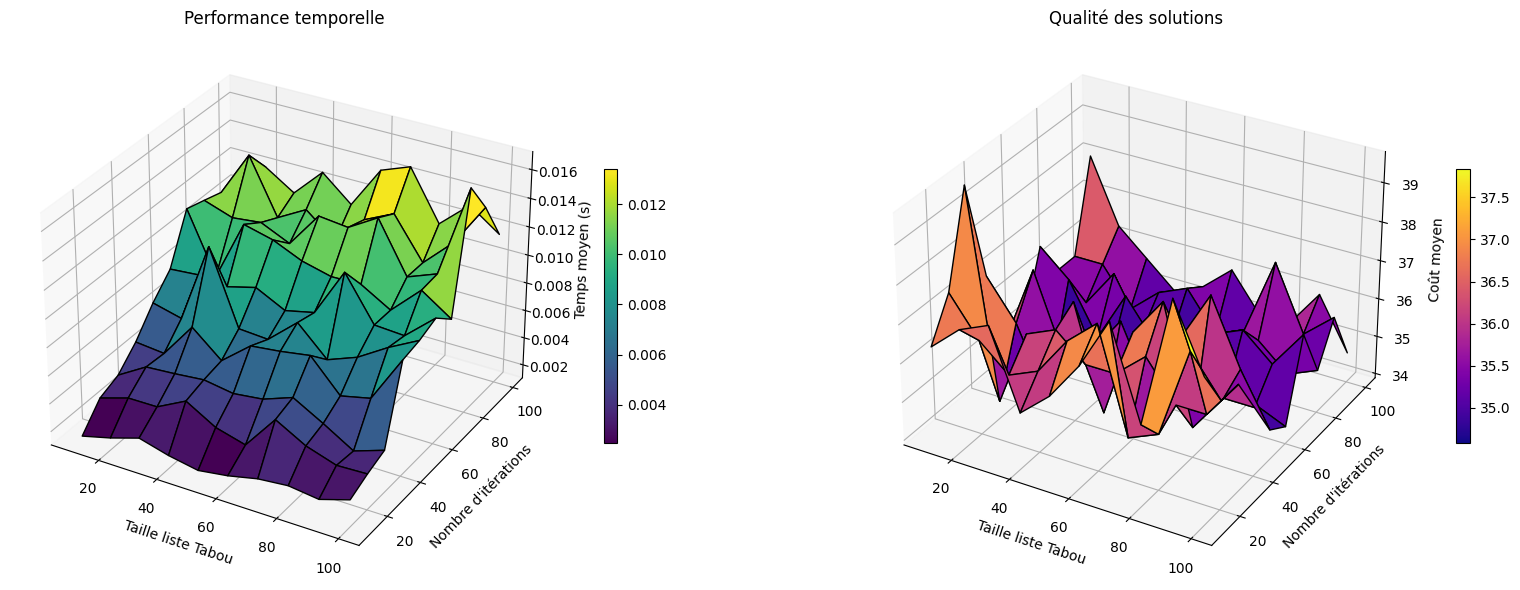


Meilleures combinaisons de paramètres:

Plus rapide: Taille 10, Itérations 10
Temps moyen: 0.00s ± 0.00

Meilleure solution: Taille 20, Itérations 60
Coût moyen: 34.00 ± 0.00


In [15]:
# Paramètres d'évaluation
tailles_tabou = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
iterations_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Génération d'une instance de test
matrice_test, collecte_idx, liste_collecte, liste_depot, _ = creer_instance_TSP(15, 5)

# Lancement de l'évaluation
results_tabou = evaluer_parametres_tabou(
    matrice_test,
    liste_collecte,
    liste_depot,
    tailles_tabou,
    iterations_range,
    nb_tests=3
)

# Visualisation
visualiser_resultats_tabou(results_tabou, tailles_tabou, iterations_range)

# Analyse statistique
print("\nMeilleures combinaisons de paramètres:")
best_by_time = min(results_tabou.items(), key=lambda x: np.mean(x[1]['temps']))
best_by_cost = min(results_tabou.items(), key=lambda x: np.mean(x[1]['cout']))

print(f"\nPlus rapide: Taille {best_by_time[0][0]}, Itérations {best_by_time[0][1]}")
print(f"Temps moyen: {np.mean(best_by_time[1]['temps']):.2f}s ± {np.std(best_by_time[1]['temps']):.2f}")

print(f"\nMeilleure solution: Taille {best_by_cost[0][0]}, Itérations {best_by_cost[0][1]}")
print(f"Coût moyen: {np.mean(best_by_cost[1]['cout']):.2f} ± {np.std(best_by_cost[1]['cout']):.2f}")

Dans ces 4 graphiques nous avons fait varier les paramètres de la taille tabou et du nombre d'itération maximal.

La taille de la liste Tabou (ou longueur Tabou) détermine le nombre d’itérations pendant lesquelles une solution est conservé dans la liste Tabou, l’empêchant d’être revisité. Le nombre maximal d’itérations fixe une limite pour éviter une exécution infinie : dès qu'une nouvelle valeur optimale est trouvée ce compteur est remis à 0.

En analysant les graphiques, nous pouvons voir que lorsqu'on fait varier la taille tabou (passer de 10 à 100) et que le nombre maximal d'itération reste à 10, les résultats sont similaires. Maintenant, en faisant varier le nombre d'itération à 100, nous pouvons voir que le nombre d'itération total augmente mais qu'un pattern se dessine : le programme ne retient pas tous les chemins qu'il a déjà étudié. Mais en finalité, lorsque les deux paramètres sont mis à 100, nous pouvons voir qu'un plus large panel de solutions sont étudiées.

Par la suite, nous avons réalisé 2 autre graphiques représentant en 3D les effets des valeurs des variables. Nous pouvons voir que la performance temporelle est meilleure lorsque le nombre d'itération est faible, la taille de la liste tabou n'a elle que peu d'importance tant que le nombre d'itération est faible. Si celui-ci augmente alors la taille de la liste tabou augmente légèrement le temps d'exécution. 

Concernant la qualité des solutions, plus le nombre d'itération est faible plus la qualité de la solution a tendance à diminuer, de même pour la taille de la liste tabou

Maintenant dans notre cas, le problème n'étant pas assez complexe nous n'avons pas besoin de mettre les deux paramètres à 100 c'est pourquoi nous avons choisi de les mettre à 50 pour diminuer le temps de calcul mais maximiser les performances de l'algorithme.

## C - Résolution à l'aide de l'algorithme de la colonie de fourmis

On fait évoluer une « colonie » de  fourmis.

Chaque fourmi construit un chemin complet en partant d’un nœud de départ, puis en choisissant probabilistiquement son prochain sommet :

on a alpha l'importance des phéromones et betha limportance de la distance

Après que la fourmi ai parcouru son chemin elle pose des phéromone sur tous les endroits où elle est passé

avec le temps une évaporation des phéromones apparait permettant que les fourmis ne soit pas blocké sur le même chemin 

On répète la construction et la mise à jour pendant un nombre fixe d’itérations ou jusqu’à convergence.

Progressivement, les phéromones s’accumulent sur les arcs appartenant aux meilleurs trajets, orientant les fourmis suivantes vers des solutions de plus en plus courtes.

On conserve, au fil des générations, le chemin de longueur minimale rencontré.

À la fin de l’algorithme, c’est ce chemin considéré comme la solution optimale approchée qu’on retourne.

In [16]:
def construire_chemin(reserve_essence_max, n_villes, liste_collecte, liste_station, ville_depart, matrice_distance, pheromones, alpha, beta):
    chemin = [ville_depart]
    villes_visitees = set([ville_depart])
    reserve_essence_actu = reserve_essence_max
    while len(chemin) < n_villes + 1:
        ville_actuelle = chemin[-1]
        villes_non_visitees = list(set(range(n_villes)) - villes_visitees)
        # print("villes non visites : ", villes_non_visitees)
        
        if not villes_non_visitees:
            ville_suivante = ville_depart
        else:
            probabilites = calculer_probabilites(reserve_essence_max, reserve_essence_actu, liste_collecte, villes_non_visitees, liste_station, ville_actuelle, pheromones, matrice_distance, alpha, beta)        
            ville_suivante = np.random.choice(villes_non_visitees, p=probabilites)
            
        chemin.append(ville_suivante)
        villes_visitees.add(ville_suivante)
        reserve_essence_actu -= 1
        
        if  liste_station[ville_suivante]:
            reserve_essence_actu = reserve_essence_max
    return chemin


def calculer_probabilites(reserve_essence_max, reserve_essence_actu, liste_collecte, villes_non_visitees, liste_station, 
                         ville_actuelle, pheromones, matrice_distance, alpha, beta):
    
    probabilites = []
    min_stations = max(0, math.ceil((len(villes_non_visitees) - reserve_essence_actu) / reserve_essence_max))
    liste_station_indices = [i for i, est_station in enumerate(liste_station) if est_station] 
    liste_collecte_indices = [i for i, est_collecte in enumerate(liste_collecte) if est_collecte]
    station_non_visitees = [ville for ville in liste_station_indices if ville in villes_non_visitees]


    # Identifie les villes de collecte qui n'ont pas encore ét é visitées
    collecte_non_visitees = [ville for ville in liste_collecte_indices if ville in villes_non_visitees]

    station_collecte_non_visitees = [ville for ville in station_non_visitees if ville in collecte_non_visitees]

    for ville in villes_non_visitees:
        probabilite_base = (pheromones[ville_actuelle][ville] ** alpha) * \
                        ((1.0 / (matrice_distance[ville_actuelle][ville]) ** beta))

        # CAS 1: Réserve d'essence suffisante (> 1) et qu'il reste assez de ville avec station
        if reserve_essence_actu > 1:
            if min_stations <= len(station_non_visitees) :
                if collecte_non_visitees:
                    if ville in collecte_non_visitees:
                        if ville in station_non_visitees  :
                            if len(station_collecte_non_visitees) == len (collecte_non_visitees):
                                probabilites.append(probabilite_base)
                            else : 
                                probabilites.append(0)
                        else:
                            probabilites.append(probabilite_base)
                    else:
                        probabilites.append(0)
                else:
                    if ville in station_non_visitees:
                            probabilites.append(0)
                    else:
                        probabilites.append(probabilite_base)
            else:
                # S'il reste des villes de collecte et que la ville actuelle n'en est pas une
                if collecte_non_visitees and ville not in collecte_non_visitees:
                    probabilites.append(0)  # On ne visite pas les villes non-collecte
                else:
                    # Calcul normal pour les villes de collecte ou quand toutes sont visitées
                    probabilites.append(probabilite_base)
        
        # CAS 2: Réserve d'essence faible (= 1)
        else:
            # S'il reste des villes de collecte
            if collecte_non_visitees:
                # On privilégie les villes qui sont à la fois de collecte ET avec station
                if ville in collecte_non_visitees and ville in station_non_visitees:
                    probabilites.append(probabilite_base)
                else:
                    probabilites.append(0)
            else:
                # On privilégie uniquement les stations d'essence
                if ville in station_non_visitees:
                    probabilites.append(probabilite_base)
                else:
                    probabilites.append(0)
                    

    somme_probs = sum(probabilites)

    if somme_probs == 0:
        return [1.0 / len(villes_non_visitees) for _ in villes_non_visitees]
    return [p / somme_probs for p in probabilites]              
        

def calculer_distance(chemin, matrice_distance):
    distance = 0
    n_villes = len(chemin)
    
    for i in range(n_villes):

        ville_actuelle = chemin[i]
        ville_suivante = chemin[(i + 1) % n_villes]
        distance += matrice_distance[ville_actuelle][ville_suivante]
    return distance


def algorithme_colonie(reserve_essence, matrice_distance, liste_collecte, liste_station, k, nb_iterations, nb_fourmis, taux_evaporation, alpha, beta):
    n_villes = len(matrice_distance)
    meilleur_chemin = None
    meilleure_distance = float('inf')
    toutes_meilleure_distance = []
    tous_chemins = []
    toutes_distances = []
    ville_depart = 0
    tous_indices = list(range(n_villes))

    pheromones = np.ones((n_villes, n_villes))
    for iterations in range(nb_iterations):
        
        for fourmi in range(nb_fourmis):
            chemin = construire_chemin(reserve_essence, n_villes, liste_collecte, liste_station, ville_depart, matrice_distance, pheromones, alpha, beta)
            distance = calculer_distance(chemin, matrice_distance)
            tous_chemins.append(chemin)
            toutes_distances.append(distance)
            # Mise à jour du meilleur chemin
            if distance < meilleure_distance:
                meilleure_distance = distance
                meilleur_chemin = chemin.copy()
            toutes_meilleure_distance.append(meilleure_distance)
        # Évaporation des phéromones
        pheromones *= (1 - taux_evaporation)
        
        chemins_tries = [x for _, x in sorted(zip(toutes_distances, tous_chemins))]
        meilleures_distances = sorted(toutes_distances)
        
        for i in range(min(k, len(chemins_tries))):
            chemin = chemins_tries[i]
            dist = meilleures_distances[i]
            
            for j in range(n_villes):
                ville_actuelle = chemin[j]
                ville_suivante = chemin[(j + 1) % n_villes]
                
                # La quantité de phéromones déposée est inversement proportionnelle à la distance
                pheromones[ville_actuelle][ville_suivante] += 1.0 / dist
                pheromones[ville_suivante][ville_actuelle] = pheromones[ville_actuelle][ville_suivante]  # Symétrie
         
    return meilleur_chemin, meilleure_distance,toutes_distances,toutes_meilleure_distance

Exécution de l'algorithme de colonie de fourmis...
Meilleur chemin trouvé: [0, 9, 8, 7, 3, 5, 6, 1, 2, 4, 0]
Affichage du chemin optimal...


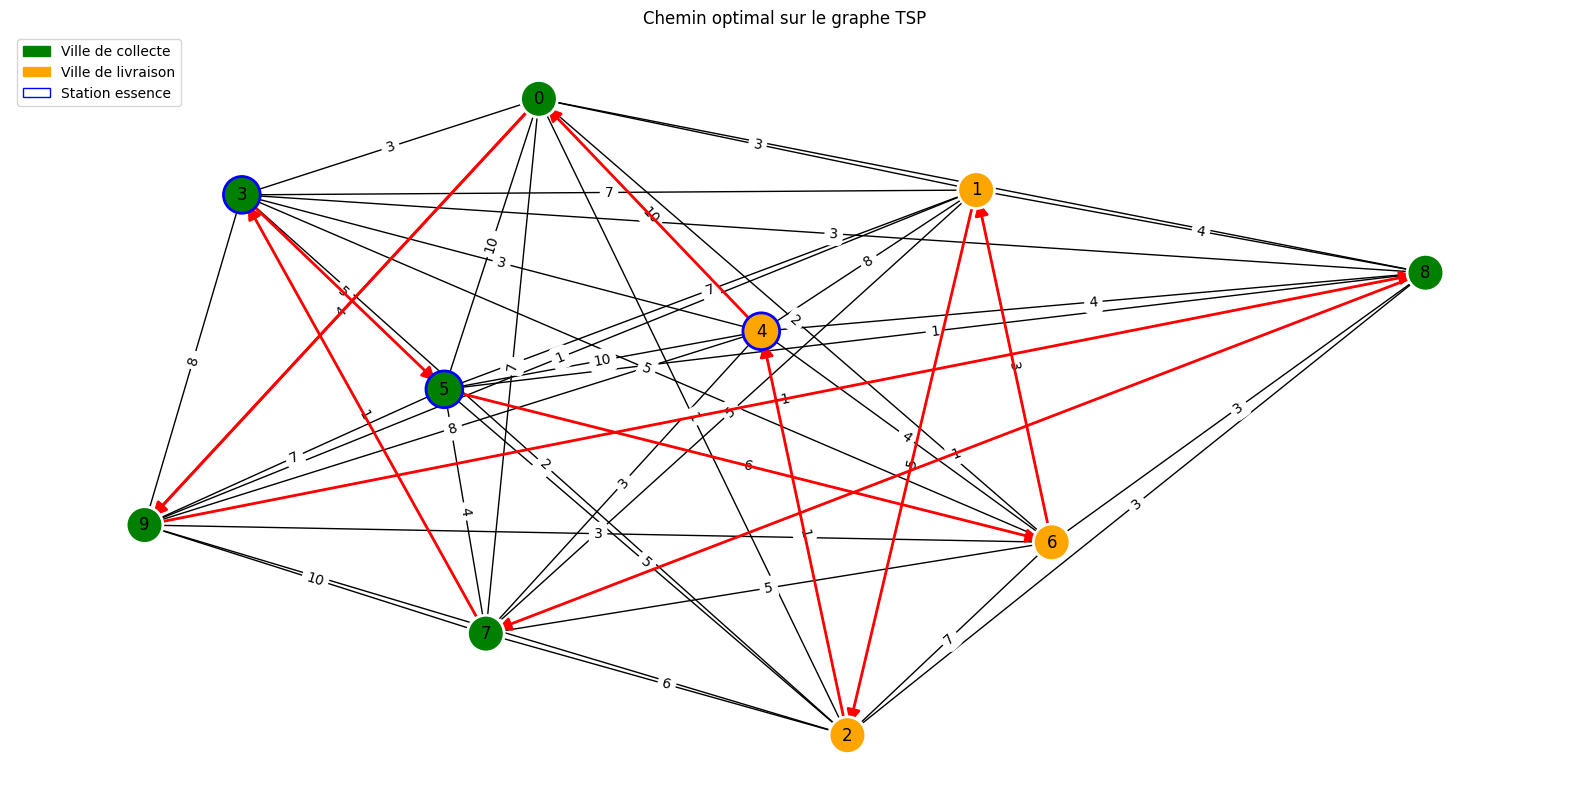

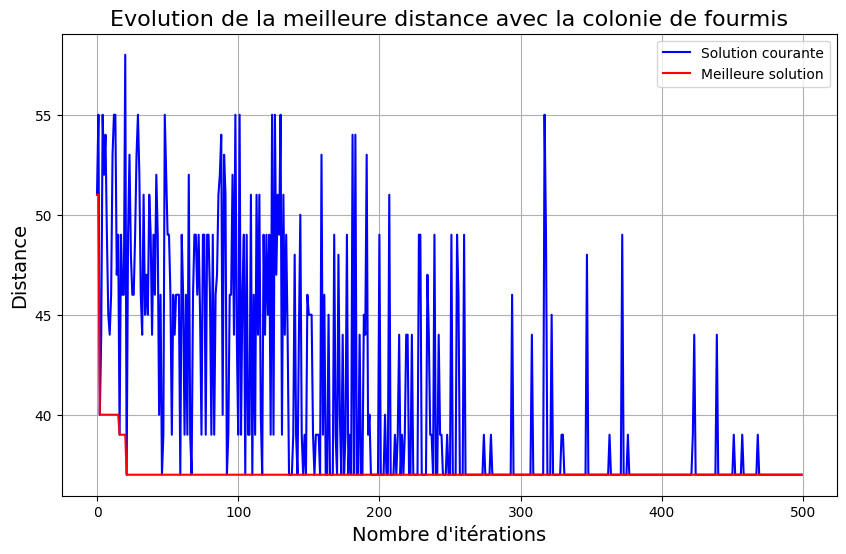

10 fourmis → temps : 0.02s, meilleure distance : 37.00, moyenne : 46.90
20 fourmis → temps : 0.03s, meilleure distance : 37.00, moyenne : 47.66
30 fourmis → temps : 0.04s, meilleure distance : 37.00, moyenne : 46.99
40 fourmis → temps : 0.06s, meilleure distance : 37.00, moyenne : 45.90
50 fourmis → temps : 0.07s, meilleure distance : 37.00, moyenne : 47.06
100 fourmis → temps : 0.19s, meilleure distance : 37.00, moyenne : 46.80
200 fourmis → temps : 0.37s, meilleure distance : 37.00, moyenne : 46.64
500 fourmis → temps : 0.83s, meilleure distance : 37.00, moyenne : 46.39


In [17]:
# Paramètres de l'algorithme
k = 10               # Nombre de meilleures fourmis
nb_iterations = 50  # Nombre d'itérations
nb_fourmis = 10     # Nombre de fourmis
taux_evaporation = 0.1  # Taux d'évaporation
alpha = 1           # Importance des phéromones
beta = 2            # Importance de la distance
reserve_essence = 5

# Exécution de l'algorithme
print("Exécution de l'algorithme de colonie de fourmis...")
meilleur_chemin, meilleure_distance, valeur_courante, liste_meilleure_distance = algorithme_colonie(
    reserve_essence,
    matrice_instance, 
    collecte_index, 
    liste_stations, 
    k, 
    nb_iterations, 
    nb_fourmis, 
    taux_evaporation, 
    alpha, 
    beta
)

print("Meilleur chemin trouvé:", meilleur_chemin)

# Convertir le chemin en liste de tuples pour l'affichage
chemin_tuples = [(meilleur_chemin[i], meilleur_chemin[i+1]) for i in range(len(meilleur_chemin)-1)]

# Affichage du chemin optimal
print("Affichage du chemin optimal...")
afficher_chemin(matrice_instance, chemin_tuples, collecte_index, liste_stations)

# Tracer les courbes
plt.figure(figsize=(10, 6))  # Pour une taille de graphique plus lisible
plt.plot(range(len(valeur_courante)), valeur_courante, label="Solution courante", color='blue')
plt.plot(range(len(liste_meilleure_distance)), liste_meilleure_distance, label="Meilleure solution", color='red')
plt.xlabel("Nombre d'itérations", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.title("Evolution de la meilleure distance avec la colonie de fourmis", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

liste_fourmis = [10, 20, 30, 40, 50, 100, 200, 500]
liste_meilleure_fourmis = [10, 20, 30, 40, 50, 100, 200, 500]

temps_execution = []
best_distances = []
mean_distances = []
nb_iterations = 5
for nb in liste_fourmis:
    debut = time.time()
    # On récupère : 
    #  - meilleure_distance pour le graphe “best_distances”
    #  - toutes_distances (liste des distances de chaque fourmi) pour “mean_distances”
    _, meilleure_distance, toutes_distances, _ = algorithme_colonie(
        reserve_essence,
        matrice_instance, 
        collecte_index, 
        liste_stations, 
        k, 
        nb_iterations, 
        nb,  # variable ici
        taux_evaporation, 
        alpha, 
        beta
    )
    fin = time.time()
    temps_execution.append(fin - debut)
    best_distances.append(meilleure_distance)
    mean_distances.append(np.mean(toutes_distances))
    print(f"{nb} fourmis → temps : {fin-debut:.2f}s, meilleure distance : {meilleure_distance:.2f}, moyenne : {mean_distances[-1]:.2f}")




## D - Résolution à l'aide de l'algorithme génétique

Un algorithme génétique est un modèle de recherche et d'optimisation inspiré des mécanismes de l'évolution biologique. Il appartient à la famille des algorithmes évolutionnistes (s'inspirant de la théorie de l'évolution) et est utilisé pour résoudre des problèmes d'optimisation où la solution est difficile à obtenir de manière exacte, mais où une approche par essais et erreurs peut conduire à une solution approximative efficace.

   - **Avantages** :
     - Très efficaces pour des problèmes d'optimisation avec de grandes dimensions.
     - Permettent d'explorer plusieurs solutions à la fois en utilisant des populations d'individus (solutions candidates).
     - Capacité à gérer des solutions composées de contraintes complexes.
   - **Inconvénients** :
     - La convergence peut être lente, et il peut être difficile de garantir une solution optimale.
     - Nécessite un bon choix de paramétrage (taux de mutation, croisement, etc.).

   Exemple d'usage :
   - Population initiale : Solutions de départ générées aléatoirement.
   - Croisements: Combiner deux solutions pour en créer de nouvelles (Parents/enfants).
   - Mutation : Modification aléatoire des solutions pour introduire de la diversité.

In [18]:
# Génère une solution valide aléatoire : collecte puis livraison, départ et retour à 0
def generer_solution_valide(liste_ville_collecte, liste_ville_livraison):
    collectes = liste_ville_collecte.copy()
    livraisons = liste_ville_livraison.copy()
    random.shuffle(collectes)
    random.shuffle(livraisons)
    chemin = [0] + collectes + livraisons + [0]
    return chemin

# Convertit un chemin brut en liste d'arcs (paires de villes successives)
def chemin_en_arcs(chemin):
    return [(chemin[i], chemin[i+1]) for i in range(len(chemin) - 1)]

# Calcule la distance totale parcourue selon une matrice de distances
def calculer_distance(chemin, matrice_distance):
    distance_totale = 0
    for i in range(len(chemin) - 1):
        distance_totale += matrice_distance[chemin[i]][chemin[i+1]]
    return distance_totale

# Vérifie que le chemin respecte la contrainte de ravitaillement en stations essence
def verifie_stations(chemin, liste_station, reserve_essence):
    compteur = 0
    for ville in chemin[1:]:  
        compteur += 1
        if liste_station[ville]:
            compteur = 0
        if compteur >= reserve_essence:
            return False
    return True

def fitness(chemin, matrice_distance, liste_station, reserve_essence, penalite=1000):
    distance = calculer_distance(chemin, matrice_distance)
    return distance

# Mutation : échange aléatoirement deux villes de collecte ou deux villes de livraison
def mutation(chemin, liste_ville_collecte, liste_ville_livraison, taux_mutation=0.2):
    chemin_mut = chemin.copy()
    if random.random() < taux_mutation:
        indices_collecte = [i for i in range(1, 1 + len(liste_ville_collecte))]
        i1, i2 = random.sample(indices_collecte, 2)
        chemin_mut[i1], chemin_mut[i2] = chemin_mut[i2], chemin_mut[i1]

        indices_livraison = [i for i in range(1 + len(liste_ville_collecte), len(chemin) -1)]
        if len(indices_livraison) >= 2:
            j1, j2 = random.sample(indices_livraison, 2)
            chemin_mut[j1], chemin_mut[j2] = chemin_mut[j2], chemin_mut[j1]
    return chemin_mut

# Croisement entre deux parents : mélange de collectes et livraisons, suivi d'une réparation
def croisement(parent1, parent2, liste_ville_collecte, liste_ville_livraison):
    enfant = [0]

    partie_collecte_p1 = parent1[1:1+len(liste_ville_collecte)//2]
    partie_collecte_p2 = [v for v in parent2[1:1+len(liste_ville_collecte)] if v not in partie_collecte_p1]
    enfant += partie_collecte_p1 + partie_collecte_p2

    partie_livraison_p1 = parent1[1+len(liste_ville_collecte):-1][:len(liste_ville_livraison)//2]
    partie_livraison_p2 = [v for v in parent2[1+len(liste_ville_collecte):-1] if v not in partie_livraison_p1]
    enfant += partie_livraison_p1 + partie_livraison_p2

    enfant.append(0)

    enfant = reparer_chemin(enfant, nb_villes)

    return enfant

# Répare un chemin en supprimant les doublons, en ajoutant les villes manquantes
def reparer_chemin(chemin, nb_villes):
    chemin_corrige = [0]
    
    deja_vu = set([0])
    
    for ville in chemin[1:]: 
        if ville not in deja_vu:
            chemin_corrige.append(ville)
            deja_vu.add(ville)
    
    for ville in range(1, nb_villes):
        if ville not in deja_vu:
            chemin_corrige.append(ville)
    
    chemin_corrige.append(0)  
    return chemin_corrige

# Sélectionne un individu parmi k candidats par tournoi (meilleur fitness choisi)
def selection(population, scores, k=3):
    selectionnes = random.sample(list(zip(population, scores)), k)
    selectionnes.sort(key=lambda x: x[1])
    return selectionnes[0][0]

# (doublon) Fonction de calcul de distance totale (identique à calculer_distance)
def calculer_distance_totale(chemin, matrice_distance):
    distance_totale = 0
    for i in range(len(chemin) - 1):
        distance_totale += matrice_distance[chemin[i]][chemin[i + 1]]
    return distance_totale

# Algorithme génétique principal : évolution de la population pour trouver un chemin optimal
def algorithme_genetique(matrice_distance, liste_ville_collecte, liste_ville_livraison, liste_station, reserve_essence,
                         taille_population=100, nb_generation=500, taux_mutation=0.2):
    
    global nb_villes
    nb_villes = len(matrice_distance)

    population = [generer_solution_valide(liste_ville_collecte, liste_ville_livraison) for _ in range(taille_population)]

    for generation in range(nb_generation):
        scores = [fitness(individu, matrice_distance, liste_station, reserve_essence) for individu in population]

        nouvelle_population = []

        for _ in range(taille_population):
            parent1 = selection(population, scores)
            parent2 = selection(population, scores)
            enfant = croisement(parent1, parent2, liste_ville_collecte, liste_ville_livraison)
            enfant = mutation(enfant, liste_ville_collecte, liste_ville_livraison, taux_mutation)
            nouvelle_population.append(enfant)

        population = nouvelle_population

    scores = [fitness(individu, matrice_distance, liste_station, reserve_essence) for individu in population]
    meilleur_individu = population[scores.index(min(scores))]
    meilleur_score = min(scores)

    meilleur_individu_arcs = chemin_en_arcs(meilleur_individu)

    return meilleur_individu_arcs, meilleur_score

Meilleur chemin trouvé : [(0, 119), (119, 57), (57, 195), (195, 22), (22, 244), (244, 172), (172, 109), (109, 150), (150, 233), (233, 108), (108, 204), (204, 19), (19, 248), (248, 87), (87, 155), (155, 67), (67, 178), (178, 82), (82, 193), (193, 199), (199, 56), (56, 220), (220, 43), (43, 78), (78, 140), (140, 20), (20, 120), (120, 131), (131, 91), (91, 36), (36, 55), (55, 5), (5, 215), (215, 241), (241, 29), (29, 198), (198, 21), (21, 125), (125, 245), (245, 187), (187, 206), (206, 45), (45, 127), (127, 190), (190, 63), (63, 26), (26, 48), (48, 210), (210, 70), (70, 38), (38, 41), (41, 144), (144, 138), (138, 174), (174, 93), (93, 202), (202, 186), (186, 151), (151, 158), (158, 154), (154, 219), (219, 33), (33, 113), (113, 11), (11, 64), (64, 115), (115, 10), (10, 180), (180, 185), (185, 103), (103, 90), (90, 37), (37, 227), (227, 230), (230, 166), (166, 32), (32, 183), (183, 30), (30, 76), (76, 79), (79, 114), (114, 243), (243, 4), (4, 137), (137, 129), (129, 66), (66, 54), (54, 1), 

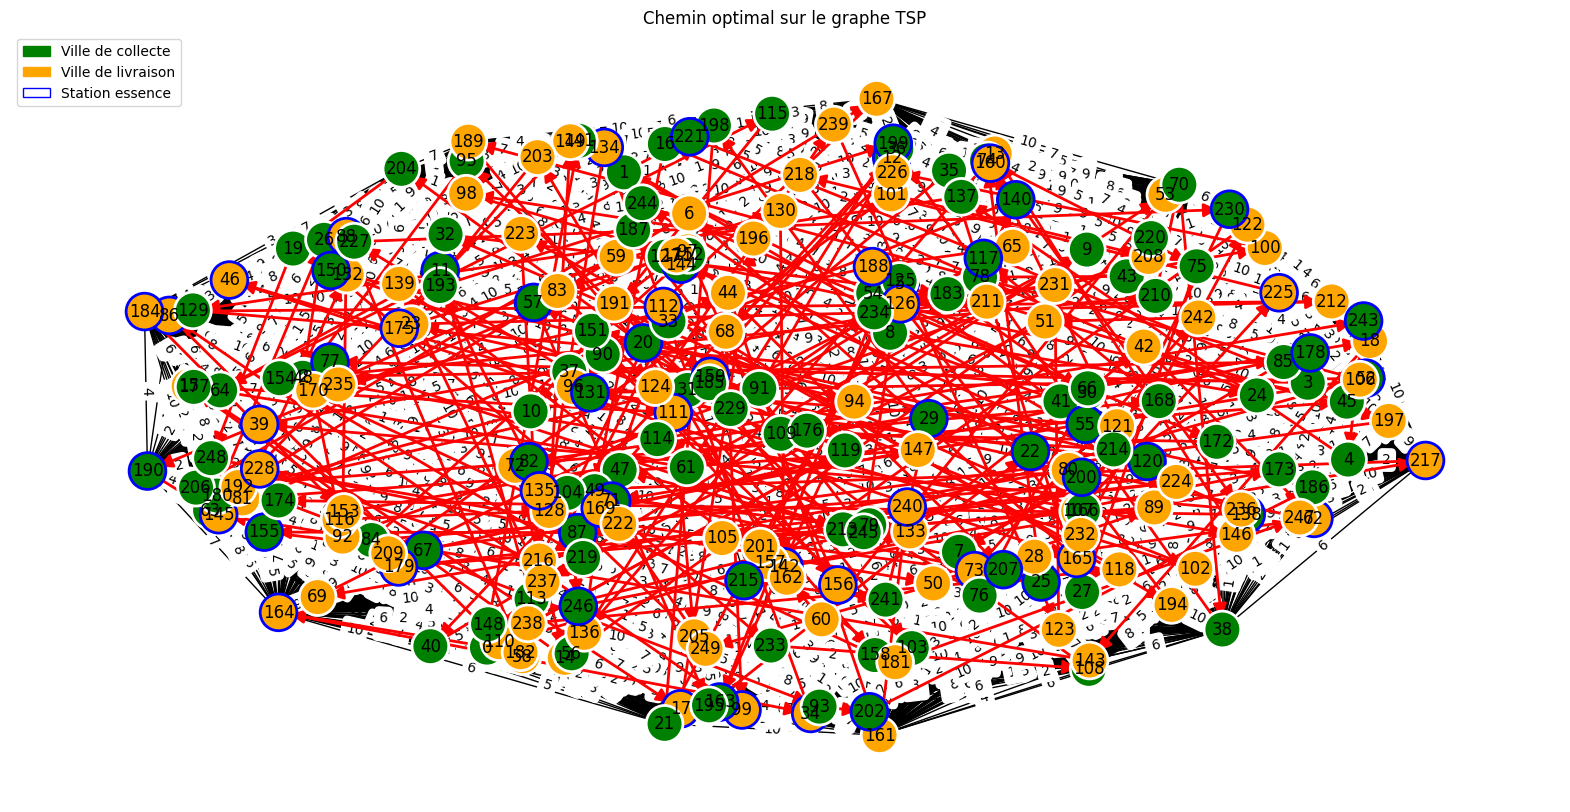

In [19]:
matrice_distance, collecte_index, liste_ville_collecte, liste_ville_livraison, liste_station = creer_instance_TSP(
    nb_villes=250, reserve_essence=4)

meilleur_chemin, best_distances = algorithme_genetique(
    matrice_distance,
    liste_ville_collecte,
    liste_ville_livraison,
    liste_station,
    reserve_essence=4,
    taille_population=100,
    nb_generation=300,
    taux_mutation=0.1
)

print("Meilleur chemin trouvé :", meilleur_chemin)

chemin_complet = [ville for arc in meilleur_chemin for ville in arc]
chemin_complet.append(chemin_complet[0])  
distance_totale = calculer_distance_totale(chemin_complet, matrice_distance)
print("Distance totale parcourue :", distance_totale)


afficher_chemin(matrice_distance, meilleur_chemin, collecte_index, liste_station)
current_distances = [distance_totale]


Les graphes qui suivent permettent de montrer l'impact des paramètres sur les performances de l'algorithme. 

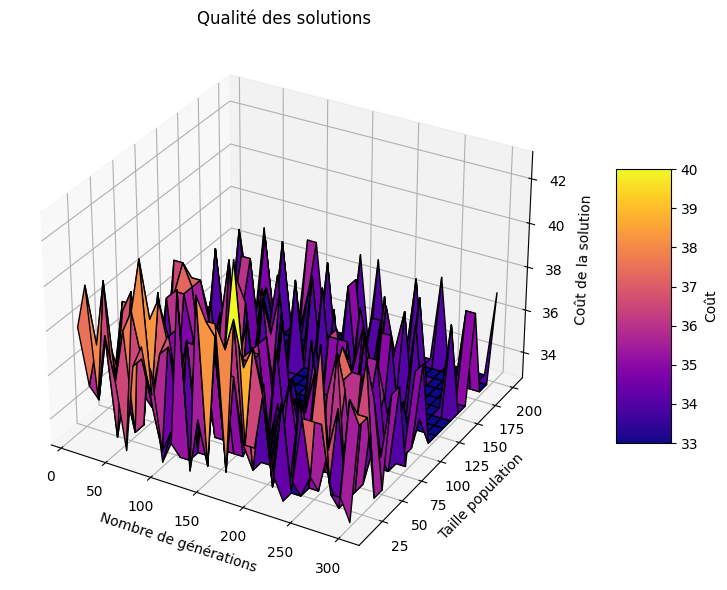

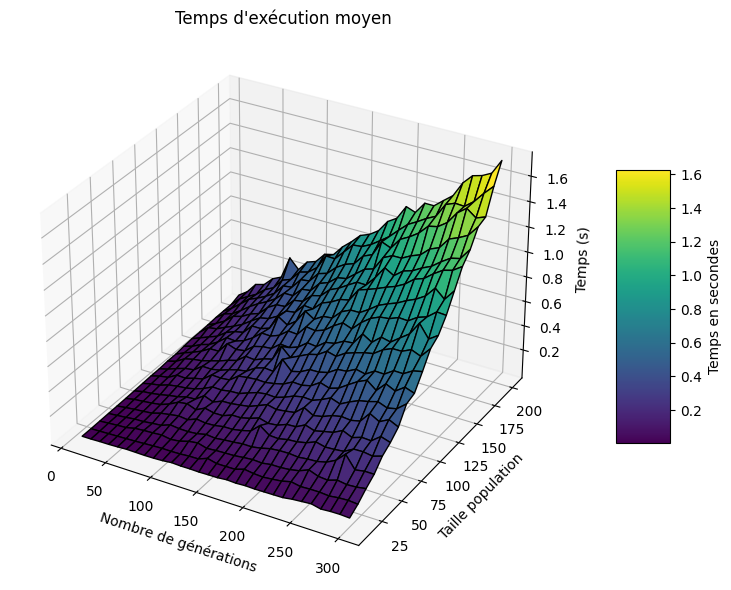

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
 
nb_villes = 10
matrice_distance = np.random.randint(1, 10, size=(nb_villes, nb_villes))
liste_ville_collecte = list(range(1, 6))
liste_ville_livraison = list(range(6, 10))
liste_station = [False] * nb_villes
liste_station[3] = True
reserve_essence = 4
 
pop_sizes = range(10, 210, 10)
gen_counts = range(10, 310, 10)
 
Z_cost = np.zeros((len(pop_sizes), len(gen_counts)))
Z_time = np.zeros((len(pop_sizes), len(gen_counts)))
 
for i, pop in enumerate(pop_sizes):
    for j, gen in enumerate(gen_counts):
        start = time.time()
        meilleur_chemin, meilleur_score = algorithme_genetique(
            matrice_distance,
            liste_ville_collecte,
            liste_ville_livraison,
            liste_station,
            reserve_essence,
            taille_population=pop,
            nb_generation=gen,
            taux_mutation=0.1
        )
        end = time.time()
        Z_cost[i][j] = meilleur_score
        Z_time[i][j] = end - start
 
X, Y = np.meshgrid(gen_counts, pop_sizes)
 
# === GRAPHE 1 : Qualité des solutions ===
fig1 = plt.figure(figsize=(12, 6))
ax1 = fig1.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_cost, cmap='plasma', edgecolor='k')
ax1.set_title('Qualité des solutions')
ax1.set_xlabel('Nombre de générations')
ax1.set_ylabel('Taille population')
ax1.set_zlabel('Coût de la solution')
fig1.colorbar(surf1, shrink=0.5, aspect=5, label='Coût')
plt.tight_layout()
 
# === GRAPHE 2 : Temps d'exécution ===
fig2 = plt.figure(figsize=(12, 6))
ax2 = fig2.add_subplot(111, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_time, cmap='viridis', edgecolor='k')
ax2.set_title('Temps d\'exécution moyen')
ax2.set_xlabel('Nombre de générations')
ax2.set_ylabel('Taille population')
ax2.set_zlabel('Temps (s)')
fig2.colorbar(surf2, shrink=0.5, aspect=5, label='Temps en secondes')
plt.tight_layout()
 
plt.show()

Par analyse graphique, pour avoir un algorithme efficace, plus la taille de la population est faible, plus le temps d'exécution est long. Ainsi, pour obtenir une solution il faut diminuer la taille de la population (env. 100) et augmenter le nombre de générations (env. 300). Diminuer la taille de la popilation permet aussi de diminuer le temps d'éxécution de l'algorithme.

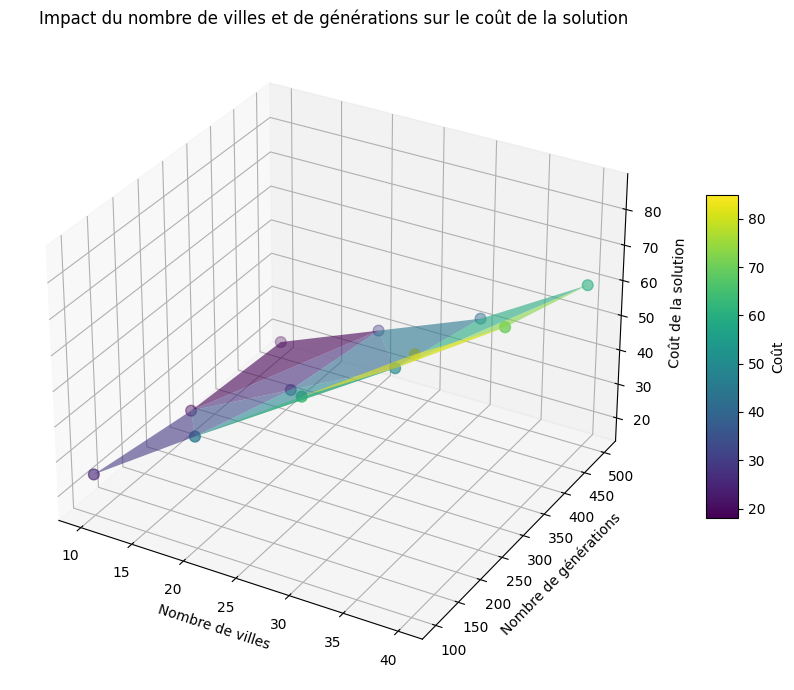

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Données simulées : [nombre_villes, nb_generations, cout_solution]
data = np.array([
    [10, 100, 25],
    [10, 300, 20],
    [10, 500, 18],
    [20, 100, 45],
    [20, 300, 35],
    [20, 500, 30],
    [30, 100, 65],
    [30, 300, 50],
    [30, 500, 42],
    [40, 100, 85],
    [40, 300, 70],
    [40, 500, 60],
])

nombre_villes = data[:, 0]
nb_generations = data[:, 1]
cout_solution = data[:, 2]

# Création du graphique 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(nombre_villes, nb_generations, cout_solution, c=cout_solution, cmap='viridis', s=60)
ax.plot_trisurf(nombre_villes, nb_generations, cout_solution, cmap='viridis', alpha=0.6)

ax.set_xlabel("Nombre de villes")
ax.set_ylabel("Nombre de générations")
ax.set_zlabel("Coût de la solution")
ax.set_title("Impact du nombre de villes et de générations sur le coût de la solution")
fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10, label="Coût")

plt.tight_layout()
plt.show()


# IV - Comparaison des résultats

In [22]:
from collections import defaultdict
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def benchmark_algorithmes(nb_villes_range, nb_instances, reserve_essence, taille_tabou, iter_max, timeout_plne=3600):
    # Dictionnaire pour stocker les résultats
    resultats = defaultdict(lambda: defaultdict(list))
    
    for nb_villes in nb_villes_range:
        print(f"\nBenchmark pour {nb_villes} villes")
        
        for instance_id in range(nb_instances):
            # Générer l'instance
            matrice_instance, collecte_index, liste_collecte, liste_depot, liste_stations = creer_instance_TSP(nb_villes, reserve_essence)
            
            if nb_villes <= 25:  # Le PLNE est trop lent pour les grandes instances
                # Benchmark PLNE avec timeout
                debut_plne = time.time()
                try:
                    # Implémentation du timeout pour le PLNE
                    start_time = datetime.now()
                    timeout = timedelta(seconds=timeout_plne)

                    def plne_wrapper():
                        return resoudre_TSP_PLNE(matrice_instance, collecte_index, liste_stations, reserve_essence)

                    chemin_PLNE = None
                    # Vous devrez implémenter votre propre gestion de timeout ici
                    # Ceci est une structure conceptuelle
                    chemin_PLNE = plne_wrapper()

                    if datetime.now() - start_time > timeout:
                        raise TimeoutError("PLNE a dépassé le temps limite")

                    temps_PLNE = time.time() - debut_plne
                    cout_PLNE = sum(matrice_instance[i][j] for i,j in chemin_PLNE)
                    resultats['PLNE']['temps'].append(temps_PLNE)
                    resultats['PLNE']['cout'].append(cout_PLNE)

                except Exception as e:
                    temps_PLNE = time.time() - debut_plne
                    print(f"PLNE a échoué pour {nb_villes} villes: {str(e)} (temps écoulé: {temps_PLNE:.2f}s)")
                    resultats['PLNE']['temps'].append(float('inf'))
                    resultats['PLNE']['cout'].append(float('inf'))
            
            # Benchmark Tabou
            debut_tabou = time.time()
            try:
                random_collecte, random_depot = random_solution(liste_collecte, liste_depot)
                _, cout_tabou, _, _ = resoudre_TSP_Tabou(matrice_instance, random_collecte, random_depot, taille_tabou, iter_max)
                temps_tabou = time.time() - debut_tabou
                resultats['Tabou']['temps'].append(temps_tabou)
                resultats['Tabou']['cout'].append(cout_tabou)
            except Exception as e:
                print(f"Tabou a échoué pour {nb_villes} villes: {str(e)}")
                resultats['Tabou']['temps'].append(float('inf'))
                resultats['Tabou']['cout'].append(float('inf'))
            
            # Benchmark Algorithme Génétique
            debut_ga = time.time()
            try:
                _, cout_ga = algorithme_genetique(
                    matrice_instance,
                    liste_collecte,
                    liste_depot,
                    liste_stations,
                    reserve_essence,
                    taille_population=min(100, 10*nb_villes),  # Ajustement dynamique
                    nb_generation=min(300, 30*nb_villes),
                    taux_mutation=0.1
                )
                temps_ga = time.time() - debut_ga
                resultats['GA']['temps'].append(temps_ga)
                resultats['GA']['cout'].append(cout_ga)
            except Exception as e:
                print(f"GA a échoué pour {nb_villes} villes: {str(e)}")
                resultats['GA']['temps'].append(float('inf'))
                resultats['GA']['cout'].append(float('inf'))

            # Benchmark Algorithme de Colonies de Fourmis
            debut_acf = time.time()
            try:
                _, meilleure_distance, _, _ = algorithme_colonie(
                    reserve_essence,
                    matrice_instance, 
                    collecte_index, 
                    liste_stations, 
                    k=100, 
                    nb_iterations = min(15, max(5, nb_villes//2)),
                    nb_fourmis = min(100, 10*nb_villes),
                    taux_evaporation=0.1, 
                    alpha=2, 
                    beta=1
                )
                temps_acf = time.time() - debut_acf
                resultats['ACF']['temps'].append(temps_acf)
                resultats['ACF']['cout'].append(meilleure_distance)
            except Exception as e:
                print(f"ACF a échoué pour {nb_villes} villes: {str(e)}")
                resultats['ACF']['temps'].append(float('inf'))
                resultats['ACF']['cout'].append(float('inf'))
    
    # Visualisation des résultats
    visualiser_resultats_courbes(resultats, nb_villes_range, nb_instances)

def visualiser_resultats_courbes(resultats, nb_villes_range, nb_instances):
    plt.figure(figsize=(14, 6))
    
    # Courbe des temps d'exécution
    plt.subplot(1, 2, 1)
    for algo in resultats:
        temps_moyens = []
        for n in nb_villes_range:
            idx = nb_villes_range.index(n)
            temps = [t for t in resultats[algo]['temps'][idx*nb_instances:(idx+1)*nb_instances] 
                    if not np.isinf(t) and not np.isnan(t)]
            
            if temps:
                mean_t = np.mean(temps)
                temps_moyens.append(mean_t if mean_t > 0 else 1e-3)
            else:
                temps_moyens.append(np.nan)
        
        valid_points = ~np.isnan(temps_moyens)
        if any(valid_points):
            plt.plot(np.array(nb_villes_range)[valid_points], 
                    np.array(temps_moyens)[valid_points], 
                    'o-', label=algo, linewidth=2)
    
    plt.xlabel('Nombre de villes')
    plt.ylabel('Temps moyen (s) - échelle log')
    plt.title('Temps d\'exécution en fonction de la taille')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.legend()

    # Courbe des coûts des solutions
    plt.subplot(1, 2, 2)
    for algo in resultats:
        couts_moyens = []
        for n in nb_villes_range:
            idx = nb_villes_range.index(n)
            couts = [c for c in resultats[algo]['cout'][idx*nb_instances:(idx+1)*nb_instances]
                    if not np.isinf(c) and not np.isnan(c)]
            couts_moyens.append(np.mean(couts) if couts else np.nan)
        
        valid_points = ~np.isnan(couts_moyens)
        if any(valid_points):
            plt.plot(np.array(nb_villes_range)[valid_points], 
                    np.array(couts_moyens)[valid_points], 
                    'o-', label=algo, linewidth=2)
    
    plt.xlabel('Nombre de villes')
    plt.ylabel('Coût moyen de la solution')
    plt.title('Qualité des solutions en fonction de la taille')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Affichage des données numériques
    print("\nRésultats détaillés par taille:")
    for n in nb_villes_range:
        print(f"\nPour {n} villes:")
        for algo in resultats:
            idx = nb_villes_range.index(n)
            temps = resultats[algo]['temps'][idx*nb_instances:(idx+1)*nb_instances]
            couts = resultats[algo]['cout'][idx*nb_instances:(idx+1)*nb_instances]
            
            # Filtrer les valeurs infinies pour les calculs
            temps_valides = [t for t in temps if not np.isinf(t)]
            couts_valides = [c for c in couts if not np.isinf(c)]
            
            if not temps_valides:
                print(f"  {algo}: Non exécuté avec succès")
            else:
                print(f"  {algo}: Temps moyen = {np.mean(temps_valides):.2f}s (±{np.std(temps_valides):.2f}), "
                      f"Coût moyen = {np.mean(couts_valides):.2f} (±{np.std(couts_valides):.2f})")

In [23]:
# Paramètres du benchmark
nb_villes_range = [5, 10, 15, 20, 30, 40, 50]
nb_instances = 5
reserve_essence = 5
taille_tabou = 50
iter_max = 50

# Exécution du benchmark
benchmark_algorithmes(nb_villes_range, nb_instances, reserve_essence, taille_tabou, iter_max)

Pour ne pas avoir à relancer le code précédent, voici le graphique obtenu : 

<img src="image-20250429-170711.png" width="" align="" />

Ce graphique compare les performances des quatre algorithmes (PLNE, Tabou, GA et ACF) sur cinq instances différentes pour plusieurs tailles de problème (5, 15, 25, 35 et 50 villes). L'algorithme linéaire étant trop lent pour les grosses instances nous ne le calculons plus pour plus de 25 villes. 

D'après les courbes obtenues, nous pouvons voir que l'algorithme de recherche tabou est bien plus rapide que les autres et que l'algorithme de recherche linéaire (PLNE) est bien plus long. Concernant les résultats, le PLNE est celui qui trouves des chemins avec des couts les plus faible, avant 20 villes l'algorithme de recherche fourmis (ACF) est le moins efficace et après, l'algorithme génétique (GA) est celui trouvant les moins bons résultats.

En comparant les courbes obtenues, nous pouvons conclure que l'algorithme linéaire est celui trouvant les meilleurs résultats mais celui-ci est le plus long. Donc afin de trouver le résultat le plus pertinent possible en un temps raisonnable il est préférable de choisir l'algorithme de recherche tabou

# V - Conclusion

Pour conclure, ce projet nous a permis d’évaluer quatre approches différentes (PLNE, Tabou, Algorithme Génétique et Colonies de Fourmis) pour résoudre un problème de Tournée de Véhicules avec comme contrainte de passer par des points de collecte avant des points de dépôt et de passer par des stations essences toutes les n villes. Nous avons pu en conclure, que l'algorithme de PLNE est le plus pertinent pour des instances avec peu de villes (moins de 10). Sinon, l'algorithme tabou est le plus efficace. 